In [25]:
import os
import warnings
warnings.filterwarnings('ignore')
from skgarden import MondrianForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
from sklearn.metrics import mean_squared_error

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams

import pandas as pd
import time
from sklearn.metrics import r2_score
import rrcf

In [26]:
def score_for_res(pred, trueval) :
    u2 = (pred-trueval)**2
    v2 = (trueval-trueval.mean())**2
    
    return 1-(u2.sum()/v2.sum())

In [27]:
def partial_train(mtr, X_test, y_test):
    y_pred, y_std = mtr.predict(X_test, return_std=True)
    mtr.partial_fit(X_test, y_test)
    #print('pred : %f, std: %f, y: %f'%(y_pred, y_std, y_test))
    return y_pred, y_std

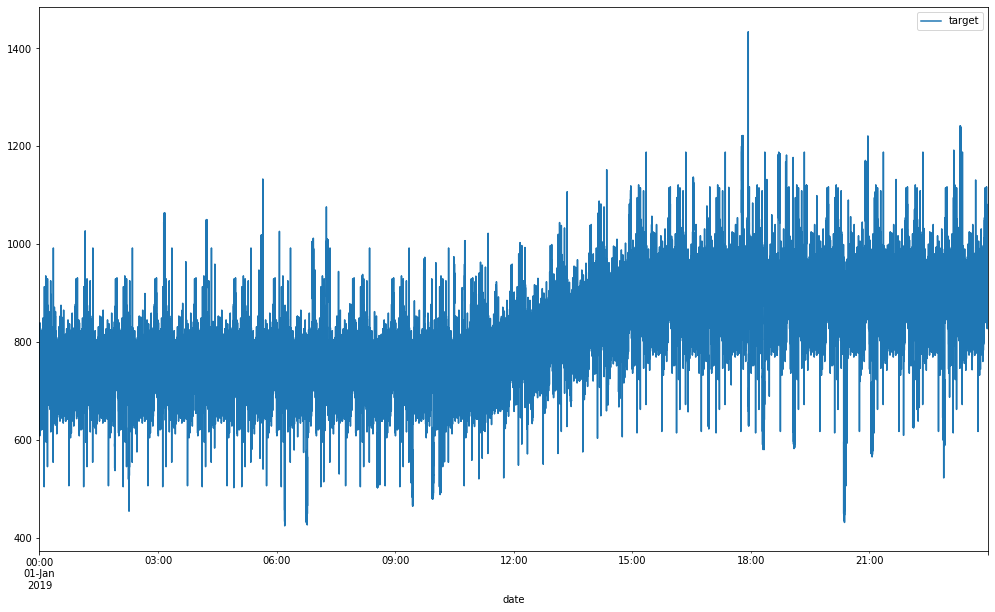

In [28]:
network = pd.read_csv('C:/Users/HakkyuKim/Desktop/Challenge/initial_training_data.csv', index_col='date', parse_dates=['date'])
network.head()

rcParams['figure.figsize'] = 17,10
network.describe()
network.plot()

In [29]:
network.describe()

,target
count,86400.000000
mean,808.433553
std,97.663811
min,424.000000
25%,735.000000
50%,801.000000
75%,881.000000
max,1434.000000


In [30]:
#construct forest of empty RCTrees

num_trees = 40
shingle_size = 60
tree_size = 256


forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

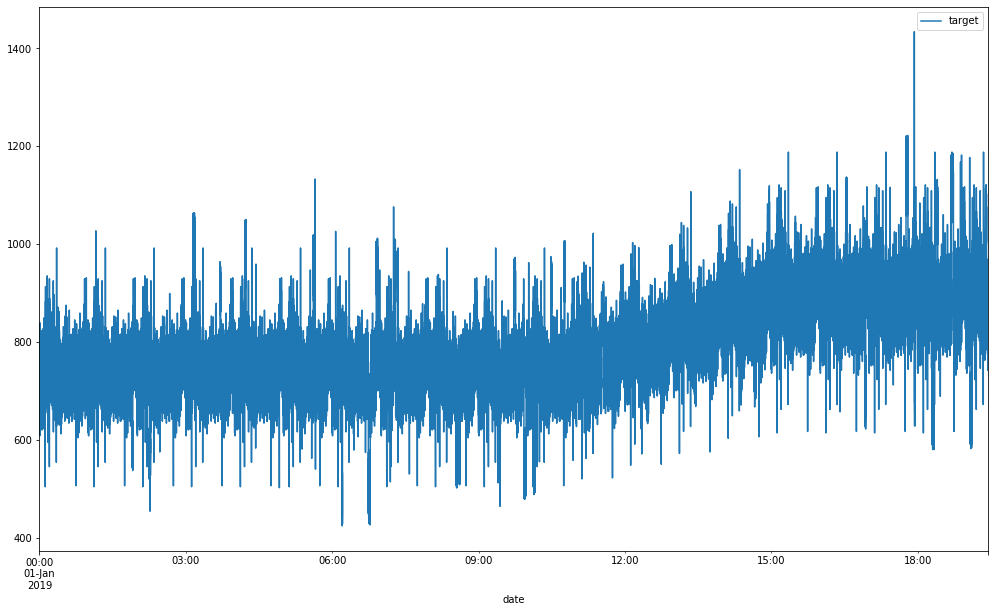

In [31]:
#train data 정제
ntw_clean = network.copy()

train_len = 70000
ntw_clean = ntw_clean[:train_len]

avg_codisp = {}
train_mean = ntw_clean.mean()

ntw_clean.plot()

In [32]:
start = time.time()



for index in range(0, train_len) :
    point = float(ntw_clean[index:index+1].values) #get one by one
    #print(point.size)
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(point, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data        
        ntw_clean.iloc[index] = ntw_clean[index-5:index].mean()
        
print("time :", time.time() - start)

time : 863.5518743991852


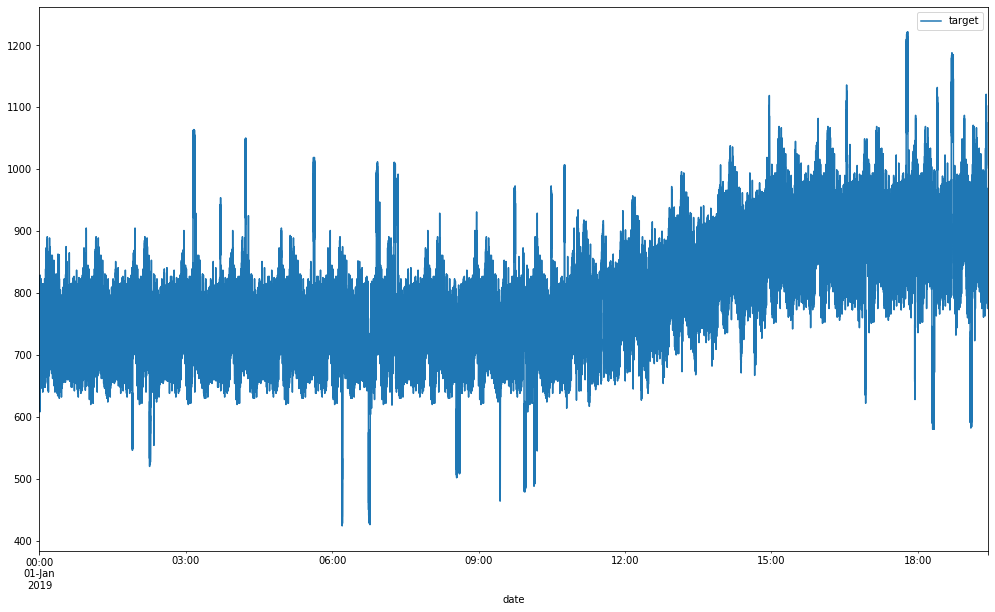

In [39]:

ntw_clean.plot()


In [34]:
avg_codisp

network[0:5]['target'].values.mean()

673.6

In [35]:
#train set만들기
'''
tmp = ntw_clean.shift(1)
tmp2 = ntw_clean.shift(2)
tmp3 = ntw_clean.shift(3)

ntw_prev = ntw_clean.copy()
ntw_prev['prev1'] = tmp['target']
ntw_prev['prev2'] = tmp2['target']
ntw_prev['prev3'] = tmp3['target']

ntw_prev = ntw_prev[4:]
ntw_prev.tail()
'''

"\ntmp = ntw_clean.shift(1)\ntmp2 = ntw_clean.shift(2)\ntmp3 = ntw_clean.shift(3)\n\nntw_prev = ntw_clean.copy()\nntw_prev['prev1'] = tmp['target']\nntw_prev['prev2'] = tmp2['target']\nntw_prev['prev3'] = tmp3['target']\n\nntw_prev = ntw_prev[4:]\nntw_prev.tail()\n"

In [36]:


#training은 clean한 data로, test는 clean하지 않은 data를 rrcf로 다시 정제하면서 진행할거임



#xt = [network[10000:10001], network.iloc[10001], network.iloc[10002]]


In [37]:
print(type(float(ntw_clean[0:1]['target'].values)))


<class 'float'>


In [38]:
mfr = MondrianForestRegressor(random_state = 1, n_estimators=100, bootstrap=True)
for i in range(7, len(ntw_clean)):
    X_train = pd.Series()
    X_train['prev1'] = float(ntw_clean[i-7:i-6]['target'].values)
    X_train['prev2'] = float(ntw_clean[i-6:i-5]['target'].values)
    X_train['prev3'] = float(ntw_clean[i-5:i-4]['target'].values)
    y_train = (ntw_clean[i:i+1]['target'].values)
    mfr.partial_fit(X_train.values.reshape(1, -1), y_train)

prediction = np.array([])
stdeviation = np.array([])

#일단 Test mean은 train mean과 같게 시작
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0

print("time :", time.time() - start)

time : 2677.5910778045654


In [15]:

tmp = ntw_clean[len(ntw_clean)-5:len(ntw_clean)]['target'].values


In [40]:
cleaned = np.array([])

xt = pd.Series()

xt['prev1'] = float(network[70000-7:70000-6]['target'].values)
xt['prev2'] = float(network[70000-6:70000-5]['target'].values)
xt['prev3'] = float(network[70000-5:70000-4]['target'].values)

#prev1이 가장 과거, prev3이 가장 최신
#20번째부터 새로 들어오는 애

for i in range(0, 5000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[70000+i:70000+i+1]['target'].values
    

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+70000
    #yt의 anomaly여부 판단
    for tree in forest :
        if len(tree.leaves) > tree_size :
            tree.forget_point(index-tree_size)
            
        tree.insert_point(yt, index=index)
        
        if not index in avg_codisp :
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees
    #avg_codisp은 (각 tree 이 point를 anomaly로 생각하는 정도)의 평균
    mean = np.array(list(avg_codisp.values())).mean()
    std = np.array(list(avg_codisp.values())).std()
        
    z = (avg_codisp[index] - mean)/std
    if z > 3.0 or z < -3.0 :
        #if abs(z-score) is over 3.0
        #replace the value with the mean of training data
        yt = test_sum/test_num
        
        
    cleaned = np.append(cleaned, [yt])
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    
    tmp =np.roll(tmp, -1)
    tmp[4] = yt
    print(tmp)
    print(xt)
    xt['prev1'] = xt['prev2']
    xt['prev2'] = xt['prev3']
    xt['prev3'] = tmp[0]
    
    test_sum += yt
    test_num += 1
    
    
    prediction = np.append(prediction, [y_pred])
    stdeviation = np.append(stdeviation, [y_std])
    

    

[898. 889. 976. 932. 951.]
prev1    938.0
prev2    901.0
prev3    843.0
dtype: float64
[889. 976. 932. 951. 850.]
prev1    901.0
prev2    843.0
prev3    898.0
dtype: float64
[976. 932. 951. 850. 924.]
prev1    843.0
prev2    898.0
prev3    889.0
dtype: float64
[932. 951. 850. 924. 925.]
prev1    898.0
prev2    889.0
prev3    976.0
dtype: float64
[951. 850. 924. 925. 934.]
prev1    889.0
prev2    976.0
prev3    932.0
dtype: float64
[850. 924. 925. 934. 819.]
prev1    976.0
prev2    932.0
prev3    951.0
dtype: float64
[924. 925. 934. 819. 823.]
prev1    932.0
prev2    951.0
prev3    850.0
dtype: float64
[925. 934. 819. 823. 813.]
prev1    951.0
prev2    850.0
prev3    924.0
dtype: float64
[934. 819. 823. 813. 889.]
prev1    850.0
prev2    924.0
prev3    925.0
dtype: float64
[819. 823. 813. 889. 887.]
prev1    924.0
prev2    925.0
prev3    934.0
dtype: float64
[823. 813. 889. 887. 907.]
prev1    925.0
prev2    934.0
prev3    819.0
dtype: float64
[813. 889. 887. 907. 905.]
prev1    934.0
p

[887. 895. 813. 830. 811.]
prev1    788.0
prev2    859.0
prev3    934.0
dtype: float64
[895. 813. 830. 811. 922.]
prev1    859.0
prev2    934.0
prev3    887.0
dtype: float64
[813. 830. 811. 922. 848.]
prev1    934.0
prev2    887.0
prev3    895.0
dtype: float64
[830. 811. 922. 848. 858.]
prev1    887.0
prev2    895.0
prev3    813.0
dtype: float64
[811. 922. 848. 858. 844.]
prev1    895.0
prev2    813.0
prev3    830.0
dtype: float64
[922. 848. 858. 844. 875.]
prev1    813.0
prev2    830.0
prev3    811.0
dtype: float64
[848. 858. 844. 875. 862.]
prev1    830.0
prev2    811.0
prev3    922.0
dtype: float64
[858. 844. 875. 862. 943.]
prev1    811.0
prev2    922.0
prev3    848.0
dtype: float64
[844. 875. 862. 943. 905.]
prev1    922.0
prev2    848.0
prev3    858.0
dtype: float64
[875. 862. 943. 905. 913.]
prev1    848.0
prev2    858.0
prev3    844.0
dtype: float64
[862. 943. 905. 913. 804.]
prev1    858.0
prev2    844.0
prev3    875.0
dtype: float64
[943. 905. 913. 804. 873.]
prev1    844.0
p

[976. 920. 866. 889. 886.]
prev1    857.0
prev2    813.0
prev3    922.0
dtype: float64
[920. 866. 889. 886. 831.]
prev1    813.0
prev2    922.0
prev3    976.0
dtype: float64
[866. 889. 886. 831. 868.]
prev1    922.0
prev2    976.0
prev3    920.0
dtype: float64
[889. 886. 831. 868. 911.]
prev1    976.0
prev2    920.0
prev3    866.0
dtype: float64
[886. 831. 868. 911. 830.]
prev1    920.0
prev2    866.0
prev3    889.0
dtype: float64
[831. 868. 911. 830. 850.]
prev1    866.0
prev2    889.0
prev3    886.0
dtype: float64
[868. 911. 830. 850. 841.]
prev1    889.0
prev2    886.0
prev3    831.0
dtype: float64
[911. 830. 850. 841. 882.]
prev1    886.0
prev2    831.0
prev3    868.0
dtype: float64
[830. 850. 841. 882. 884.]
prev1    831.0
prev2    868.0
prev3    911.0
dtype: float64
[850. 841. 882. 884. 857.]
prev1    868.0
prev2    911.0
prev3    830.0
dtype: float64
[841. 882. 884. 857. 874.]
prev1    911.0
prev2    830.0
prev3    850.0
dtype: float64
[882. 884. 857. 874. 835.]
prev1    830.0
p

[882. 940. 887. 877. 848.]
prev1    929.0
prev2    917.0
prev3    925.0
dtype: float64
[940. 887. 877. 848. 833.]
prev1    917.0
prev2    925.0
prev3    882.0
dtype: float64
[887. 877. 848. 833. 885.]
prev1    925.0
prev2    882.0
prev3    940.0
dtype: float64
[877. 848. 833. 885. 875.]
prev1    882.0
prev2    940.0
prev3    887.0
dtype: float64
[848. 833. 885. 875. 925.]
prev1    940.0
prev2    887.0
prev3    877.0
dtype: float64
[833.         885.         875.         925.         790.78952992]
prev1    887.0
prev2    877.0
prev3    848.0
dtype: float64
[885.         875.         925.         790.78952992 985.        ]
prev1    877.0
prev2    848.0
prev3    833.0
dtype: float64
[875.         925.         790.78952992 985.         916.        ]
prev1    848.0
prev2    833.0
prev3    885.0
dtype: float64
[925.         790.78952992 985.         916.         872.        ]
prev1    833.0
prev2    885.0
prev3    875.0
dtype: float64
[790.78952992 985.         916.         872.         911.

[827. 833. 857. 897. 862.]
prev1    841.0
prev2    852.0
prev3    911.0
dtype: float64
[833. 857. 897. 862. 894.]
prev1    852.0
prev2    911.0
prev3    827.0
dtype: float64
[857. 897. 862. 894. 859.]
prev1    911.0
prev2    827.0
prev3    833.0
dtype: float64
[897. 862. 894. 859. 819.]
prev1    827.0
prev2    833.0
prev3    857.0
dtype: float64
[862. 894. 859. 819. 911.]
prev1    833.0
prev2    857.0
prev3    897.0
dtype: float64
[894. 859. 819. 911. 821.]
prev1    857.0
prev2    897.0
prev3    862.0
dtype: float64
[859. 819. 911. 821. 834.]
prev1    897.0
prev2    862.0
prev3    894.0
dtype: float64
[819. 911. 821. 834. 922.]
prev1    862.0
prev2    894.0
prev3    859.0
dtype: float64
[911. 821. 834. 922. 925.]
prev1    894.0
prev2    859.0
prev3    819.0
dtype: float64
[821. 834. 922. 925. 827.]
prev1    859.0
prev2    819.0
prev3    911.0
dtype: float64
[834. 922. 925. 827. 841.]
prev1    819.0
prev2    911.0
prev3    821.0
dtype: float64
[922. 925. 827. 841. 964.]
prev1    911.0
p

[844. 880. 825. 859. 903.]
prev1    878.0
prev2    903.0
prev3    852.0
dtype: float64
[880. 825. 859. 903. 914.]
prev1    903.0
prev2    852.0
prev3    844.0
dtype: float64
[825. 859. 903. 914. 838.]
prev1    852.0
prev2    844.0
prev3    880.0
dtype: float64
[859. 903. 914. 838. 852.]
prev1    844.0
prev2    880.0
prev3    825.0
dtype: float64
[903. 914. 838. 852. 896.]
prev1    880.0
prev2    825.0
prev3    859.0
dtype: float64
[914. 838. 852. 896. 852.]
prev1    825.0
prev2    859.0
prev3    903.0
dtype: float64
[838. 852. 896. 852. 871.]
prev1    859.0
prev2    903.0
prev3    914.0
dtype: float64
[852. 896. 852. 871. 879.]
prev1    903.0
prev2    914.0
prev3    838.0
dtype: float64
[896. 852. 871. 879. 892.]
prev1    914.0
prev2    838.0
prev3    852.0
dtype: float64
[852. 871. 879. 892. 919.]
prev1    838.0
prev2    852.0
prev3    896.0
dtype: float64
[871. 879. 892. 919. 934.]
prev1    852.0
prev2    896.0
prev3    852.0
dtype: float64
[879. 892. 919. 934. 894.]
prev1    896.0
p

[834. 878. 890. 888. 769.]
prev1    864.0
prev2    843.0
prev3    841.0
dtype: float64
[878. 890. 888. 769. 879.]
prev1    843.0
prev2    841.0
prev3    834.0
dtype: float64
[890. 888. 769. 879. 896.]
prev1    841.0
prev2    834.0
prev3    878.0
dtype: float64
[888. 769. 879. 896. 888.]
prev1    834.0
prev2    878.0
prev3    890.0
dtype: float64
[769. 879. 896. 888. 940.]
prev1    878.0
prev2    890.0
prev3    888.0
dtype: float64
[879. 896. 888. 940. 825.]
prev1    890.0
prev2    888.0
prev3    769.0
dtype: float64
[896. 888. 940. 825. 850.]
prev1    888.0
prev2    769.0
prev3    879.0
dtype: float64
[888. 940. 825. 850. 872.]
prev1    769.0
prev2    879.0
prev3    896.0
dtype: float64
[940. 825. 850. 872. 829.]
prev1    879.0
prev2    896.0
prev3    888.0
dtype: float64
[825. 850. 872. 829. 855.]
prev1    896.0
prev2    888.0
prev3    940.0
dtype: float64
[850. 872. 829. 855. 886.]
prev1    888.0
prev2    940.0
prev3    825.0
dtype: float64
[872. 829. 855. 886. 925.]
prev1    940.0
p

[859. 960. 970. 967. 913.]
prev1    889.0
prev2    896.0
prev3    917.0
dtype: float64
[960. 970. 967. 913. 919.]
prev1    896.0
prev2    917.0
prev3    859.0
dtype: float64
[970. 967. 913. 919. 949.]
prev1    917.0
prev2    859.0
prev3    960.0
dtype: float64
[967. 913. 919. 949. 964.]
prev1    859.0
prev2    960.0
prev3    970.0
dtype: float64
[913. 919. 949. 964. 951.]
prev1    960.0
prev2    970.0
prev3    967.0
dtype: float64
[919. 949. 964. 951. 883.]
prev1    970.0
prev2    967.0
prev3    913.0
dtype: float64
[949. 964. 951. 883. 868.]
prev1    967.0
prev2    913.0
prev3    919.0
dtype: float64
[964. 951. 883. 868. 918.]
prev1    913.0
prev2    919.0
prev3    949.0
dtype: float64
[951. 883. 868. 918. 967.]
prev1    919.0
prev2    949.0
prev3    964.0
dtype: float64
[883. 868. 918. 967. 942.]
prev1    949.0
prev2    964.0
prev3    951.0
dtype: float64
[868. 918. 967. 942. 852.]
prev1    964.0
prev2    951.0
prev3    883.0
dtype: float64
[918. 967. 942. 852. 879.]
prev1    951.0
p

[819. 857. 947. 900. 896.]
prev1    862.0
prev2    903.0
prev3    870.0
dtype: float64
[857. 947. 900. 896. 867.]
prev1    903.0
prev2    870.0
prev3    819.0
dtype: float64
[947. 900. 896. 867. 874.]
prev1    870.0
prev2    819.0
prev3    857.0
dtype: float64
[900. 896. 867. 874. 901.]
prev1    819.0
prev2    857.0
prev3    947.0
dtype: float64
[896. 867. 874. 901. 925.]
prev1    857.0
prev2    947.0
prev3    900.0
dtype: float64
[867. 874. 901. 925. 825.]
prev1    947.0
prev2    900.0
prev3    896.0
dtype: float64
[874. 901. 925. 825. 839.]
prev1    900.0
prev2    896.0
prev3    867.0
dtype: float64
[901. 925. 825. 839. 843.]
prev1    896.0
prev2    867.0
prev3    874.0
dtype: float64
[925. 825. 839. 843. 915.]
prev1    867.0
prev2    874.0
prev3    901.0
dtype: float64
[825. 839. 843. 915. 880.]
prev1    874.0
prev2    901.0
prev3    925.0
dtype: float64
[839. 843. 915. 880. 854.]
prev1    901.0
prev2    925.0
prev3    825.0
dtype: float64
[843. 915. 880. 854. 932.]
prev1    925.0
p

[969. 945. 889. 891. 880.]
prev1    873.0
prev2    844.0
prev3    852.0
dtype: float64
[945. 889. 891. 880. 911.]
prev1    844.0
prev2    852.0
prev3    969.0
dtype: float64
[889. 891. 880. 911. 793.]
prev1    852.0
prev2    969.0
prev3    945.0
dtype: float64
[891. 880. 911. 793. 795.]
prev1    969.0
prev2    945.0
prev3    889.0
dtype: float64
[880. 911. 793. 795. 869.]
prev1    945.0
prev2    889.0
prev3    891.0
dtype: float64
[911. 793. 795. 869. 825.]
prev1    889.0
prev2    891.0
prev3    880.0
dtype: float64
[793. 795. 869. 825. 819.]
prev1    891.0
prev2    880.0
prev3    911.0
dtype: float64
[795. 869. 825. 819. 892.]
prev1    880.0
prev2    911.0
prev3    793.0
dtype: float64
[869. 825. 819. 892. 864.]
prev1    911.0
prev2    793.0
prev3    795.0
dtype: float64
[825. 819. 892. 864. 870.]
prev1    793.0
prev2    795.0
prev3    869.0
dtype: float64
[819. 892. 864. 870. 893.]
prev1    795.0
prev2    869.0
prev3    825.0
dtype: float64
[892. 864. 870. 893. 880.]
prev1    869.0
p

[884. 964. 850. 823. 844.]
prev1    909.0
prev2    895.0
prev3    889.0
dtype: float64
[964. 850. 823. 844. 885.]
prev1    895.0
prev2    889.0
prev3    884.0
dtype: float64
[850. 823. 844. 885. 886.]
prev1    889.0
prev2    884.0
prev3    964.0
dtype: float64
[823. 844. 885. 886. 857.]
prev1    884.0
prev2    964.0
prev3    850.0
dtype: float64
[844. 885. 886. 857. 949.]
prev1    964.0
prev2    850.0
prev3    823.0
dtype: float64
[885. 886. 857. 949. 994.]
prev1    850.0
prev2    823.0
prev3    844.0
dtype: float64
[886. 857. 949. 994. 942.]
prev1    823.0
prev2    844.0
prev3    885.0
dtype: float64
[857. 949. 994. 942. 864.]
prev1    844.0
prev2    885.0
prev3    886.0
dtype: float64
[949. 994. 942. 864. 866.]
prev1    885.0
prev2    886.0
prev3    857.0
dtype: float64
[994. 942. 864. 866. 969.]
prev1    886.0
prev2    857.0
prev3    949.0
dtype: float64
[942. 864. 866. 969. 889.]
prev1    857.0
prev2    949.0
prev3    994.0
dtype: float64
[864. 866. 969. 889. 911.]
prev1    949.0
p

[850. 841. 811. 790. 866.]
prev1    872.0
prev2    827.0
prev3    825.0
dtype: float64
[841. 811. 790. 866. 834.]
prev1    827.0
prev2    825.0
prev3    850.0
dtype: float64
[811. 790. 866. 834. 827.]
prev1    825.0
prev2    850.0
prev3    841.0
dtype: float64
[790. 866. 834. 827. 868.]
prev1    850.0
prev2    841.0
prev3    811.0
dtype: float64
[866. 834. 827. 868. 846.]
prev1    841.0
prev2    811.0
prev3    790.0
dtype: float64
[834. 827. 868. 846. 823.]
prev1    811.0
prev2    790.0
prev3    866.0
dtype: float64
[827. 868. 846. 823. 796.]
prev1    790.0
prev2    866.0
prev3    834.0
dtype: float64
[868. 846. 823. 796. 837.]
prev1    866.0
prev2    834.0
prev3    827.0
dtype: float64
[846. 823. 796. 837. 833.]
prev1    834.0
prev2    827.0
prev3    868.0
dtype: float64
[823. 796. 837. 833. 855.]
prev1    827.0
prev2    868.0
prev3    846.0
dtype: float64
[796. 837. 833. 855. 852.]
prev1    868.0
prev2    846.0
prev3    823.0
dtype: float64
[837. 833. 855. 852. 823.]
prev1    846.0
p

[825. 949. 907. 964. 951.]
prev1    913.0
prev2    903.0
prev3    811.0
dtype: float64
[949. 907. 964. 951. 995.]
prev1    903.0
prev2    811.0
prev3    825.0
dtype: float64
[907. 964. 951. 995. 917.]
prev1    811.0
prev2    825.0
prev3    949.0
dtype: float64
[964. 951. 995. 917. 916.]
prev1    825.0
prev2    949.0
prev3    907.0
dtype: float64
[951. 995. 917. 916. 916.]
prev1    949.0
prev2    907.0
prev3    964.0
dtype: float64
[995. 917. 916. 916. 905.]
prev1    907.0
prev2    964.0
prev3    951.0
dtype: float64
[917. 916. 916. 905. 962.]
prev1    964.0
prev2    951.0
prev3    995.0
dtype: float64
[916.         916.         905.         962.         791.91982225]
prev1    951.0
prev2    995.0
prev3    917.0
dtype: float64
[916.         905.         962.         791.91982225 791.91982225]
prev1    995.0
prev2    917.0
prev3    916.0
dtype: float64
[905.         962.         791.91982225 791.91982225 922.        ]
prev1    917.0
prev2    916.0
prev3    916.0
dtype: float64
[962.     

[887. 845. 848. 773. 785.]
prev1    815.0
prev2    821.0
prev3    859.0
dtype: float64
[845. 848. 773. 785. 850.]
prev1    821.0
prev2    859.0
prev3    887.0
dtype: float64
[848.         773.         785.         850.         792.00096923]
prev1    859.0
prev2    887.0
prev3    845.0
dtype: float64
[773.         785.         850.         792.00096923 864.        ]
prev1    887.0
prev2    845.0
prev3    848.0
dtype: float64
[785.         850.         792.00096923 864.         868.        ]
prev1    845.0
prev2    848.0
prev3    773.0
dtype: float64
[850.         792.00096923 864.         868.         792.00304698]
prev1    848.0
prev2    773.0
prev3    785.0
dtype: float64
[792.00096923 864.         868.         792.00304698 862.        ]
prev1    773.0
prev2    785.0
prev3    850.0
dtype: float64
[864.         868.         792.00304698 862.         909.        ]
prev1    785.000000
prev2    850.000000
prev3    792.000969
dtype: float64
[868.         792.00304698 862.         909.     

[893. 947. 992. 862. 896.]
prev1    916.0
prev2    932.0
prev3    957.0
dtype: float64
[947. 992. 862. 896. 985.]
prev1    932.0
prev2    957.0
prev3    893.0
dtype: float64
[992. 862. 896. 985. 896.]
prev1    957.0
prev2    893.0
prev3    947.0
dtype: float64
[862. 896. 985. 896. 928.]
prev1    893.0
prev2    947.0
prev3    992.0
dtype: float64
[896. 985. 896. 928. 940.]
prev1    947.0
prev2    992.0
prev3    862.0
dtype: float64
[985. 896. 928. 940. 862.]
prev1    992.0
prev2    862.0
prev3    896.0
dtype: float64
[896. 928. 940. 862. 980.]
prev1    862.0
prev2    896.0
prev3    985.0
dtype: float64
[928. 940. 862. 980. 911.]
prev1    896.0
prev2    985.0
prev3    896.0
dtype: float64
[940. 862. 980. 911. 823.]
prev1    985.0
prev2    896.0
prev3    928.0
dtype: float64
[862. 980. 911. 823. 893.]
prev1    896.0
prev2    928.0
prev3    940.0
dtype: float64
[980. 911. 823. 893. 952.]
prev1    928.0
prev2    940.0
prev3    862.0
dtype: float64
[911. 823. 893. 952. 877.]
prev1    940.0
p

[903. 870. 815. 895. 901.]
prev1    806.0
prev2    825.0
prev3    841.0
dtype: float64
[870. 815. 895. 901. 885.]
prev1    825.0
prev2    841.0
prev3    903.0
dtype: float64
[815. 895. 901. 885. 855.]
prev1    841.0
prev2    903.0
prev3    870.0
dtype: float64
[895. 901. 885. 855. 864.]
prev1    903.0
prev2    870.0
prev3    815.0
dtype: float64
[901. 885. 855. 864. 819.]
prev1    870.0
prev2    815.0
prev3    895.0
dtype: float64
[885. 855. 864. 819. 836.]
prev1    815.0
prev2    895.0
prev3    901.0
dtype: float64
[855. 864. 819. 836. 852.]
prev1    895.0
prev2    901.0
prev3    885.0
dtype: float64
[864. 819. 836. 852. 833.]
prev1    901.0
prev2    885.0
prev3    855.0
dtype: float64
[819. 836. 852. 833. 880.]
prev1    885.0
prev2    855.0
prev3    864.0
dtype: float64
[836. 852. 833. 880. 841.]
prev1    855.0
prev2    864.0
prev3    819.0
dtype: float64
[852. 833. 880. 841. 882.]
prev1    864.0
prev2    819.0
prev3    836.0
dtype: float64
[833. 880. 841. 882. 870.]
prev1    819.0
p

[929. 866. 855. 850. 980.]
prev1    919.0
prev2    940.0
prev3    852.0
dtype: float64
[866. 855. 850. 980. 903.]
prev1    940.0
prev2    852.0
prev3    929.0
dtype: float64
[855. 850. 980. 903. 817.]
prev1    852.0
prev2    929.0
prev3    866.0
dtype: float64
[850. 980. 903. 817. 898.]
prev1    929.0
prev2    866.0
prev3    855.0
dtype: float64
[980. 903. 817. 898. 866.]
prev1    866.0
prev2    855.0
prev3    850.0
dtype: float64
[903. 817. 898. 866. 885.]
prev1    855.0
prev2    850.0
prev3    980.0
dtype: float64
[817. 898. 866. 885. 874.]
prev1    850.0
prev2    980.0
prev3    903.0
dtype: float64
[898. 866. 885. 874. 809.]
prev1    980.0
prev2    903.0
prev3    817.0
dtype: float64
[866. 885. 874. 809. 850.]
prev1    903.0
prev2    817.0
prev3    898.0
dtype: float64
[885. 874. 809. 850. 803.]
prev1    817.0
prev2    898.0
prev3    866.0
dtype: float64
[874. 809. 850. 803. 821.]
prev1    898.0
prev2    866.0
prev3    885.0
dtype: float64
[809. 850. 803. 821. 890.]
prev1    866.0
p

[821. 886. 928. 947. 964.]
prev1    929.0
prev2    932.0
prev3    903.0
dtype: float64
[886. 928. 947. 964. 911.]
prev1    932.0
prev2    903.0
prev3    821.0
dtype: float64
[928. 947. 964. 911. 903.]
prev1    903.0
prev2    821.0
prev3    886.0
dtype: float64
[947. 964. 911. 903. 925.]
prev1    821.0
prev2    886.0
prev3    928.0
dtype: float64
[964. 911. 903. 925. 960.]
prev1    886.0
prev2    928.0
prev3    947.0
dtype: float64
[911. 903. 925. 960. 889.]
prev1    928.0
prev2    947.0
prev3    964.0
dtype: float64
[903. 925. 960. 889. 857.]
prev1    947.0
prev2    964.0
prev3    911.0
dtype: float64
[925. 960. 889. 857. 849.]
prev1    964.0
prev2    911.0
prev3    903.0
dtype: float64
[960. 889. 857. 849. 894.]
prev1    911.0
prev2    903.0
prev3    925.0
dtype: float64
[889. 857. 849. 894. 949.]
prev1    903.0
prev2    925.0
prev3    960.0
dtype: float64
[857. 849. 894. 949. 978.]
prev1    925.0
prev2    960.0
prev3    889.0
dtype: float64
[849. 894. 949. 978. 936.]
prev1    960.0
p

[ 976. 1029. 1017. 1004.  911.]
prev1    914.000000
prev2    792.538484
prev3    940.000000
dtype: float64
[1029. 1017. 1004.  911.  864.]
prev1    792.538484
prev2    940.000000
prev3    976.000000
dtype: float64
[1017. 1004.  911.  864.  916.]
prev1     940.0
prev2     976.0
prev3    1029.0
dtype: float64
[1004.  911.  864.  916. 1049.]
prev1     976.0
prev2    1029.0
prev3    1017.0
dtype: float64
[ 911.  864.  916. 1049. 1023.]
prev1    1029.0
prev2    1017.0
prev3    1004.0
dtype: float64
[ 864.  916. 1049. 1023.  938.]
prev1    1017.0
prev2    1004.0
prev3     911.0
dtype: float64
[ 916. 1049. 1023.  938.  932.]
prev1    1004.0
prev2     911.0
prev3     864.0
dtype: float64
[1049. 1023.  938.  932.  994.]
prev1    911.0
prev2    864.0
prev3    916.0
dtype: float64
[1023.  938.  932.  994.  949.]
prev1     864.0
prev2     916.0
prev3    1049.0
dtype: float64
[938. 932. 994. 949. 911.]
prev1     916.0
prev2    1049.0
prev3    1023.0
dtype: float64
[932. 994. 949. 911. 909.]
prev1  

[1014. 1004.  976.  924.  848.]
prev1    949.0
prev2    881.0
prev3    938.0
dtype: float64
[1004.  976.  924.  848.  867.]
prev1     881.0
prev2     938.0
prev3    1014.0
dtype: float64
[976. 924. 848. 867. 955.]
prev1     938.0
prev2    1014.0
prev3    1004.0
dtype: float64
[924. 848. 867. 955. 942.]
prev1    1014.0
prev2    1004.0
prev3     976.0
dtype: float64
[848. 867. 955. 942. 985.]
prev1    1004.0
prev2     976.0
prev3     924.0
dtype: float64
[867. 955. 942. 985. 967.]
prev1    976.0
prev2    924.0
prev3    848.0
dtype: float64
[955. 942. 985. 967. 980.]
prev1    924.0
prev2    848.0
prev3    867.0
dtype: float64
[942. 985. 967. 980. 992.]
prev1    848.0
prev2    867.0
prev3    955.0
dtype: float64
[985. 967. 980. 992. 974.]
prev1    867.0
prev2    955.0
prev3    942.0
dtype: float64
[967. 980. 992. 974. 913.]
prev1    955.0
prev2    942.0
prev3    985.0
dtype: float64
[980. 992. 974. 913. 945.]
prev1    942.0
prev2    985.0
prev3    967.0
dtype: float64
[992. 974. 913. 945. 

[1082. 1001. 1021.  964.  958.]
prev1    1049.000000
prev2    1017.000000
prev3     792.921139
dtype: float64
[1001. 1021.  964.  958.  959.]
prev1    1017.000000
prev2     792.921139
prev3    1082.000000
dtype: float64
[1021.  964.  958.  959.  934.]
prev1     792.921139
prev2    1082.000000
prev3    1001.000000
dtype: float64
[964. 958. 959. 934. 918.]
prev1    1082.0
prev2    1001.0
prev3    1021.0
dtype: float64
[ 958.  959.  934.  918. 1006.]
prev1    1001.0
prev2    1021.0
prev3     964.0
dtype: float64
[ 959.  934.  918. 1006.  976.]
prev1    1021.0
prev2     964.0
prev3     958.0
dtype: float64
[ 934.  918. 1006.  976.  867.]
prev1    964.0
prev2    958.0
prev3    959.0
dtype: float64
[ 918. 1006.  976.  867.  928.]
prev1    958.0
prev2    959.0
prev3    934.0
dtype: float64
[1006.  976.  867.  928.  903.]
prev1    959.0
prev2    934.0
prev3    918.0
dtype: float64
[976. 867. 928. 903. 917.]
prev1     934.0
prev2     918.0
prev3    1006.0
dtype: float64
[867. 928. 903. 917. 923

[974. 892. 877. 911. 898.]
prev1    938.0
prev2    925.0
prev3    932.0
dtype: float64
[892. 877. 911. 898. 936.]
prev1    925.0
prev2    932.0
prev3    974.0
dtype: float64
[877. 911. 898. 936. 949.]
prev1    932.0
prev2    974.0
prev3    892.0
dtype: float64
[911. 898. 936. 949. 942.]
prev1    974.0
prev2    892.0
prev3    877.0
dtype: float64
[898. 936. 949. 942. 930.]
prev1    892.0
prev2    877.0
prev3    911.0
dtype: float64
[936. 949. 942. 930. 940.]
prev1    877.0
prev2    911.0
prev3    898.0
dtype: float64
[949. 942. 930. 940. 970.]
prev1    911.0
prev2    898.0
prev3    936.0
dtype: float64
[942. 930. 940. 970. 896.]
prev1    898.0
prev2    936.0
prev3    949.0
dtype: float64
[930. 940. 970. 896. 872.]
prev1    936.0
prev2    949.0
prev3    942.0
dtype: float64
[940. 970. 896. 872. 957.]
prev1    949.0
prev2    942.0
prev3    930.0
dtype: float64
[970. 896. 872. 957. 871.]
prev1    942.0
prev2    930.0
prev3    940.0
dtype: float64
[896. 872. 957. 871. 911.]
prev1    930.0
p

[ 927.  868. 1008.  857.  864.]
prev1    864.0
prev2    896.0
prev3    929.0
dtype: float64
[ 868. 1008.  857.  864.  997.]
prev1    896.0
prev2    929.0
prev3    927.0
dtype: float64
[1008.  857.  864.  997.  980.]
prev1    929.0
prev2    927.0
prev3    868.0
dtype: float64
[857. 864. 997. 980. 882.]
prev1     927.0
prev2     868.0
prev3    1008.0
dtype: float64
[864. 997. 980. 882. 873.]
prev1     868.0
prev2    1008.0
prev3     857.0
dtype: float64
[997. 980. 882. 873. 817.]
prev1    1008.0
prev2     857.0
prev3     864.0
dtype: float64
[980. 882. 873. 817. 830.]
prev1    857.0
prev2    864.0
prev3    997.0
dtype: float64
[882. 873. 817. 830. 839.]
prev1    864.0
prev2    997.0
prev3    980.0
dtype: float64
[873. 817. 830. 839. 848.]
prev1    997.0
prev2    980.0
prev3    882.0
dtype: float64
[817. 830. 839. 848. 806.]
prev1    980.0
prev2    882.0
prev3    873.0
dtype: float64
[830. 839. 848. 806. 929.]
prev1    882.0
prev2    873.0
prev3    817.0
dtype: float64
[839. 848. 806. 929

prev1    884.0
prev2    909.0
prev3    801.0
dtype: float64
[771. 884. 903. 893. 868.]
prev1    909.0
prev2    801.0
prev3    907.0
dtype: float64
[884. 903. 893. 868. 883.]
prev1    801.0
prev2    907.0
prev3    771.0
dtype: float64
[903. 893. 868. 883. 960.]
prev1    907.0
prev2    771.0
prev3    884.0
dtype: float64
[893. 868. 883. 960. 940.]
prev1    771.0
prev2    884.0
prev3    903.0
dtype: float64
[868. 883. 960. 940. 836.]
prev1    884.0
prev2    903.0
prev3    893.0
dtype: float64
[883. 960. 940. 836. 841.]
prev1    903.0
prev2    893.0
prev3    868.0
dtype: float64
[960. 940. 836. 841. 797.]
prev1    893.0
prev2    868.0
prev3    883.0
dtype: float64
[940. 836. 841. 797. 841.]
prev1    868.0
prev2    883.0
prev3    960.0
dtype: float64
[836. 841. 797. 841. 858.]
prev1    883.0
prev2    960.0
prev3    940.0
dtype: float64
[841. 797. 841. 858. 877.]
prev1    960.0
prev2    940.0
prev3    836.0
dtype: float64
[797. 841. 858. 877. 927.]
prev1    940.0
prev2    836.0
prev3    841.

[846. 808. 874. 841. 819.]
prev1    907.0
prev2    917.0
prev3    868.0
dtype: float64
[808. 874. 841. 819. 827.]
prev1    917.0
prev2    868.0
prev3    846.0
dtype: float64
[874. 841. 819. 827. 844.]
prev1    868.0
prev2    846.0
prev3    808.0
dtype: float64
[841. 819. 827. 844. 819.]
prev1    846.0
prev2    808.0
prev3    874.0
dtype: float64
[819. 827. 844. 819. 898.]
prev1    808.0
prev2    874.0
prev3    841.0
dtype: float64
[827. 844. 819. 898. 852.]
prev1    874.0
prev2    841.0
prev3    819.0
dtype: float64
[844. 819. 898. 852. 859.]
prev1    841.0
prev2    819.0
prev3    827.0
dtype: float64
[819. 898. 852. 859. 779.]
prev1    819.0
prev2    827.0
prev3    844.0
dtype: float64
[898. 852. 859. 779. 775.]
prev1    827.0
prev2    844.0
prev3    819.0
dtype: float64
[852. 859. 779. 775. 811.]
prev1    844.0
prev2    819.0
prev3    898.0
dtype: float64
[859. 779. 775. 811. 753.]
prev1    819.0
prev2    898.0
prev3    852.0
dtype: float64
[779. 775. 811. 753. 834.]
prev1    898.0
p

[793.56317442 943.         870.         790.         872.        ]
prev1    909.0
prev2    952.0
prev3    925.0
dtype: float64
[943. 870. 790. 872. 932.]
prev1    952.000000
prev2    925.000000
prev3    793.563174
dtype: float64
[870. 790. 872. 932. 951.]
prev1    925.000000
prev2    793.563174
prev3    943.000000
dtype: float64
[790. 872. 932. 951. 929.]
prev1    793.563174
prev2    943.000000
prev3    870.000000
dtype: float64
[872. 932. 951. 929. 980.]
prev1    943.0
prev2    870.0
prev3    790.0
dtype: float64
[932. 951. 929. 980. 925.]
prev1    870.0
prev2    790.0
prev3    872.0
dtype: float64
[951. 929. 980. 925. 934.]
prev1    790.0
prev2    872.0
prev3    932.0
dtype: float64
[929. 980. 925. 934. 951.]
prev1    872.0
prev2    932.0
prev3    951.0
dtype: float64
[980. 925. 934. 951. 896.]
prev1    932.0
prev2    951.0
prev3    929.0
dtype: float64
[925. 934. 951. 896. 911.]
prev1    951.0
prev2    929.0
prev3    980.0
dtype: float64
[934. 951. 896. 911. 930.]
prev1    929.0
pre

[811. 831. 855. 860. 817.]
prev1    907.0
prev2    890.0
prev3    907.0
dtype: float64
[831. 855. 860. 817. 827.]
prev1    890.0
prev2    907.0
prev3    811.0
dtype: float64
[855. 860. 817. 827. 876.]
prev1    907.0
prev2    811.0
prev3    831.0
dtype: float64
[860. 817. 827. 876. 783.]
prev1    811.0
prev2    831.0
prev3    855.0
dtype: float64
[817. 827. 876. 783. 792.]
prev1    831.0
prev2    855.0
prev3    860.0
dtype: float64
[827. 876. 783. 792. 825.]
prev1    855.0
prev2    860.0
prev3    817.0
dtype: float64
[876.         783.         792.         825.         793.70677496]
prev1    860.0
prev2    817.0
prev3    827.0
dtype: float64
[783.         792.         825.         793.70677496 894.        ]
prev1    817.0
prev2    827.0
prev3    876.0
dtype: float64
[792.         825.         793.70677496 894.         889.        ]
prev1    827.0
prev2    876.0
prev3    783.0
dtype: float64
[825.         793.70677496 894.         889.         821.        ]
prev1    876.0
prev2    783.0


[960.         793.82261089 930.         949.         823.        ]
prev1    903.0
prev2    905.0
prev3    982.0
dtype: float64
[793.82261089 930.         949.         823.         909.        ]
prev1    905.0
prev2    982.0
prev3    960.0
dtype: float64
[930. 949. 823. 909. 898.]
prev1    982.000000
prev2    960.000000
prev3    793.822611
dtype: float64
[949. 823. 909. 898. 914.]
prev1    960.000000
prev2    793.822611
prev3    930.000000
dtype: float64
[823. 909. 898. 914. 947.]
prev1    793.822611
prev2    930.000000
prev3    949.000000
dtype: float64
[909. 898. 914. 947. 980.]
prev1    930.0
prev2    949.0
prev3    823.0
dtype: float64
[ 898.  914.  947.  980. 1000.]
prev1    949.0
prev2    823.0
prev3    909.0
dtype: float64
[ 914.  947.  980. 1000.  958.]
prev1    823.0
prev2    909.0
prev3    898.0
dtype: float64
[ 947.  980. 1000.  958.  909.]
prev1    909.0
prev2    898.0
prev3    914.0
dtype: float64
[ 980. 1000.  958.  909. 1021.]
prev1    898.0
prev2    914.0
prev3    947.0


[992. 925. 894. 856. 907.]
prev1     980.0
prev2     905.0
prev3    1013.0
dtype: float64
[925. 894. 856. 907. 951.]
prev1     905.0
prev2    1013.0
prev3     992.0
dtype: float64
[894. 856. 907. 951. 854.]
prev1    1013.0
prev2     992.0
prev3     925.0
dtype: float64
[856. 907. 951. 854. 953.]
prev1    992.0
prev2    925.0
prev3    894.0
dtype: float64
[907. 951. 854. 953. 884.]
prev1    925.0
prev2    894.0
prev3    856.0
dtype: float64
[951. 854. 953. 884. 887.]
prev1    894.0
prev2    856.0
prev3    907.0
dtype: float64
[854. 953. 884. 887. 919.]
prev1    856.0
prev2    907.0
prev3    951.0
dtype: float64
[953. 884. 887. 919. 911.]
prev1    907.0
prev2    951.0
prev3    854.0
dtype: float64
[884. 887. 919. 911. 947.]
prev1    951.0
prev2    854.0
prev3    953.0
dtype: float64
[887. 919. 911. 947. 899.]
prev1    854.0
prev2    953.0
prev3    884.0
dtype: float64
[919. 911. 947. 899. 913.]
prev1    953.0
prev2    884.0
prev3    887.0
dtype: float64
[911. 947. 899. 913. 873.]
prev1  

[1016.  945.  881.  808.  861.]
prev1    887.0
prev2    929.0
prev3    934.0
dtype: float64
[945. 881. 808. 861. 913.]
prev1     929.0
prev2     934.0
prev3    1016.0
dtype: float64
[881. 808. 861. 913. 866.]
prev1     934.0
prev2    1016.0
prev3     945.0
dtype: float64
[808. 861. 913. 866. 927.]
prev1    1016.0
prev2     945.0
prev3     881.0
dtype: float64
[861. 913. 866. 927. 982.]
prev1    945.0
prev2    881.0
prev3    808.0
dtype: float64
[913. 866. 927. 982. 987.]
prev1    881.0
prev2    808.0
prev3    861.0
dtype: float64
[866. 927. 982. 987. 932.]
prev1    808.0
prev2    861.0
prev3    913.0
dtype: float64
[927. 982. 987. 932. 938.]
prev1    861.0
prev2    913.0
prev3    866.0
dtype: float64
[ 982.  987.  932.  938. 1041.]
prev1    913.0
prev2    866.0
prev3    927.0
dtype: float64
[ 987.  932.  938. 1041.  806.]
prev1    866.0
prev2    927.0
prev3    982.0
dtype: float64
[ 932.  938. 1041.  806.  934.]
prev1    927.0
prev2    982.0
prev3    987.0
dtype: float64
[ 938. 1041.  

[896. 859. 925. 896. 883.]
prev1     899.0
prev2    1051.0
prev3     992.0
dtype: float64
[859. 925. 896. 883. 909.]
prev1    1051.0
prev2     992.0
prev3     896.0
dtype: float64
[925. 896. 883. 909. 951.]
prev1    992.0
prev2    896.0
prev3    859.0
dtype: float64
[896. 883. 909. 951. 922.]
prev1    896.0
prev2    859.0
prev3    925.0
dtype: float64
[883. 909. 951. 922. 817.]
prev1    859.0
prev2    925.0
prev3    896.0
dtype: float64
[909. 951. 922. 817. 940.]
prev1    925.0
prev2    896.0
prev3    883.0
dtype: float64
[951. 922. 817. 940. 974.]
prev1    896.0
prev2    883.0
prev3    909.0
dtype: float64
[922. 817. 940. 974. 957.]
prev1    883.0
prev2    909.0
prev3    951.0
dtype: float64
[817. 940. 974. 957. 884.]
prev1    909.0
prev2    951.0
prev3    922.0
dtype: float64
[940. 974. 957. 884. 921.]
prev1    951.0
prev2    922.0
prev3    817.0
dtype: float64
[974. 957. 884. 921. 857.]
prev1    922.0
prev2    817.0
prev3    940.0
dtype: float64
[957. 884. 921. 857. 896.]
prev1    8

[ 870. 1032.  883.  942.  907.]
prev1    909.0
prev2    905.0
prev3    911.0
dtype: float64
[1032.  883.  942.  907.  915.]
prev1    905.0
prev2    911.0
prev3    870.0
dtype: float64
[883. 942. 907. 915. 938.]
prev1     911.0
prev2     870.0
prev3    1032.0
dtype: float64
[942. 907. 915. 938. 895.]
prev1     870.0
prev2    1032.0
prev3     883.0
dtype: float64
[907. 915. 938. 895. 927.]
prev1    1032.0
prev2     883.0
prev3     942.0
dtype: float64
[915. 938. 895. 927. 985.]
prev1    883.0
prev2    942.0
prev3    907.0
dtype: float64
[ 938.  895.  927.  985. 1033.]
prev1    942.0
prev2    907.0
prev3    915.0
dtype: float64
[ 895.  927.  985. 1033.  932.]
prev1    907.0
prev2    915.0
prev3    938.0
dtype: float64
[ 927.  985. 1033.  932.  907.]
prev1    915.0
prev2    938.0
prev3    895.0
dtype: float64
[ 985. 1033.  932.  907.  985.]
prev1    938.0
prev2    895.0
prev3    927.0
dtype: float64
[1033.  932.  907.  985.  942.]
prev1    895.0
prev2    927.0
prev3    985.0
dtype: float64

[888. 867. 878. 857. 836.]
prev1    866.0
prev2    869.0
prev3    861.0
dtype: float64
[867. 878. 857. 836. 896.]
prev1    869.0
prev2    861.0
prev3    888.0
dtype: float64
[878. 857. 836. 896. 865.]
prev1    861.0
prev2    888.0
prev3    867.0
dtype: float64
[857. 836. 896. 865. 954.]
prev1    888.0
prev2    867.0
prev3    878.0
dtype: float64
[836. 896. 865. 954. 982.]
prev1    867.0
prev2    878.0
prev3    857.0
dtype: float64
[896.         865.         954.         982.         794.63532813]
prev1    878.0
prev2    857.0
prev3    836.0
dtype: float64
[865.         954.         982.         794.63532813 882.        ]
prev1    857.0
prev2    836.0
prev3    896.0
dtype: float64
[954.         982.         794.63532813 882.         978.        ]
prev1    836.0
prev2    896.0
prev3    865.0
dtype: float64
[982.         794.63532813 882.         978.         969.        ]
prev1    896.0
prev2    865.0
prev3    954.0
dtype: float64
[794.63532813 882.         978.         969.         872.

[862. 924. 864. 930. 940.]
prev1    872.0
prev2    925.0
prev3    836.0
dtype: float64
[924. 864. 930. 940. 972.]
prev1    925.0
prev2    836.0
prev3    862.0
dtype: float64
[864. 930. 940. 972. 922.]
prev1    836.0
prev2    862.0
prev3    924.0
dtype: float64
[930. 940. 972. 922. 878.]
prev1    862.0
prev2    924.0
prev3    864.0
dtype: float64
[940. 972. 922. 878. 917.]
prev1    924.0
prev2    864.0
prev3    930.0
dtype: float64
[972. 922. 878. 917. 885.]
prev1    864.0
prev2    930.0
prev3    940.0
dtype: float64
[922. 878. 917. 885. 916.]
prev1    930.0
prev2    940.0
prev3    972.0
dtype: float64
[878. 917. 885. 916. 936.]
prev1    940.0
prev2    972.0
prev3    922.0
dtype: float64
[917. 885. 916. 936. 905.]
prev1    972.0
prev2    922.0
prev3    878.0
dtype: float64
[885. 916. 936. 905. 947.]
prev1    922.0
prev2    878.0
prev3    917.0
dtype: float64
[ 916.  936.  905.  947. 1025.]
prev1    878.0
prev2    917.0
prev3    885.0
dtype: float64
[ 936.  905.  947. 1025.  957.]
prev1 

[775. 813. 843. 799. 830.]
prev1    855.0
prev2    801.0
prev3    828.0
dtype: float64
[813. 843. 799. 830. 863.]
prev1    801.0
prev2    828.0
prev3    775.0
dtype: float64
[843. 799. 830. 863. 792.]
prev1    828.0
prev2    775.0
prev3    813.0
dtype: float64
[799. 830. 863. 792. 839.]
prev1    775.0
prev2    813.0
prev3    843.0
dtype: float64
[830. 863. 792. 839. 875.]
prev1    813.0
prev2    843.0
prev3    799.0
dtype: float64
[863. 792. 839. 875. 884.]
prev1    843.0
prev2    799.0
prev3    830.0
dtype: float64
[792. 839. 875. 884. 841.]
prev1    799.0
prev2    830.0
prev3    863.0
dtype: float64
[839. 875. 884. 841. 819.]
prev1    830.0
prev2    863.0
prev3    792.0
dtype: float64
[875. 884. 841. 819. 864.]
prev1    863.0
prev2    792.0
prev3    839.0
dtype: float64
[884. 841. 819. 864. 801.]
prev1    792.0
prev2    839.0
prev3    875.0
dtype: float64
[841. 819. 864. 801. 891.]
prev1    839.0
prev2    875.0
prev3    884.0
dtype: float64
[819. 864. 801. 891. 850.]
prev1    875.0
p

[878.         911.         942.         974.         794.97325346]
prev1    915.0
prev2    905.0
prev3    964.0
dtype: float64
[911.         942.         974.         794.97325346 794.97325346]
prev1    905.0
prev2    964.0
prev3    878.0
dtype: float64
[942.         974.         794.97325346 794.97325346 794.97325346]
prev1    964.0
prev2    878.0
prev3    911.0
dtype: float64
[974.         794.97325346 794.97325346 794.97325346 794.97325346]
prev1    878.0
prev2    911.0
prev3    942.0
dtype: float64
[794.97325346 794.97325346 794.97325346 794.97325346 794.97325346]
prev1    911.0
prev2    942.0
prev3    974.0
dtype: float64
[794.97325346 794.97325346 794.97325346 794.97325346 794.97325346]
prev1    942.000000
prev2    974.000000
prev3    794.973253
dtype: float64
[794.97325346 794.97325346 794.97325346 794.97325346 794.97325346]
prev1    974.000000
prev2    794.973253
prev3    794.973253
dtype: float64
[794.97325346 794.97325346 794.97325346 794.97325346 512.        ]
prev1    794.9

[482. 654. 478. 594. 581.]
prev1    431.0
prev2    583.0
prev3    655.0
dtype: float64
[654. 478. 594. 581. 550.]
prev1    583.0
prev2    655.0
prev3    482.0
dtype: float64
[478. 594. 581. 550. 930.]
prev1    655.0
prev2    482.0
prev3    654.0
dtype: float64
[594. 581. 550. 930. 827.]
prev1    482.0
prev2    654.0
prev3    478.0
dtype: float64
[581. 550. 930. 827. 806.]
prev1    654.0
prev2    478.0
prev3    594.0
dtype: float64
[550. 930. 827. 806. 773.]
prev1    478.0
prev2    594.0
prev3    581.0
dtype: float64
[930. 827. 806. 773. 878.]
prev1    594.0
prev2    581.0
prev3    550.0
dtype: float64
[827. 806. 773. 878. 864.]
prev1    581.0
prev2    550.0
prev3    930.0
dtype: float64
[806. 773. 878. 864. 841.]
prev1    550.0
prev2    930.0
prev3    827.0
dtype: float64
[773. 878. 864. 841. 841.]
prev1    930.0
prev2    827.0
prev3    806.0
dtype: float64
[878. 864. 841. 841. 835.]
prev1    827.0
prev2    806.0
prev3    773.0
dtype: float64
[864. 841. 841. 835. 843.]
prev1    806.0
p

[608. 614. 598. 594. 594.]
prev1    679.0
prev2    666.0
prev3    597.0
dtype: float64
[614. 598. 594. 594. 670.]
prev1    666.0
prev2    597.0
prev3    608.0
dtype: float64
[598. 594. 594. 670. 609.]
prev1    597.0
prev2    608.0
prev3    614.0
dtype: float64
[594. 594. 670. 609. 636.]
prev1    608.0
prev2    614.0
prev3    598.0
dtype: float64
[594. 670. 609. 636. 594.]
prev1    614.0
prev2    598.0
prev3    594.0
dtype: float64
[670. 609. 636. 594. 678.]
prev1    598.0
prev2    594.0
prev3    594.0
dtype: float64
[609. 636. 594. 678. 616.]
prev1    594.0
prev2    594.0
prev3    670.0
dtype: float64
[636. 594. 678. 616. 704.]
prev1    594.0
prev2    670.0
prev3    609.0
dtype: float64
[594. 678. 616. 704. 612.]
prev1    670.0
prev2    609.0
prev3    636.0
dtype: float64
[678. 616. 704. 612. 685.]
prev1    609.0
prev2    636.0
prev3    594.0
dtype: float64
[616. 704. 612. 685. 671.]
prev1    636.0
prev2    594.0
prev3    678.0
dtype: float64
[704. 612. 685. 671. 614.]
prev1    594.0
p

[615. 601. 629. 593. 712.]
prev1    606.0
prev2    627.0
prev3    710.0
dtype: float64
[601. 629. 593. 712. 678.]
prev1    627.0
prev2    710.0
prev3    615.0
dtype: float64
[629. 593. 712. 678. 627.]
prev1    710.0
prev2    615.0
prev3    601.0
dtype: float64
[593. 712. 678. 627. 603.]
prev1    615.0
prev2    601.0
prev3    629.0
dtype: float64
[712. 678. 627. 603. 625.]
prev1    601.0
prev2    629.0
prev3    593.0
dtype: float64
[678. 627. 603. 625. 706.]
prev1    629.0
prev2    593.0
prev3    712.0
dtype: float64
[627. 603. 625. 706. 697.]
prev1    593.0
prev2    712.0
prev3    678.0
dtype: float64
[603. 625. 706. 697. 922.]
prev1    712.0
prev2    678.0
prev3    627.0
dtype: float64
[625. 706. 697. 922. 862.]
prev1    678.0
prev2    627.0
prev3    603.0
dtype: float64
[706. 697. 922. 862. 897.]
prev1    627.0
prev2    603.0
prev3    625.0
dtype: float64
[697. 922. 862. 897. 843.]
prev1    603.0
prev2    625.0
prev3    706.0
dtype: float64
[922. 862. 897. 843. 893.]
prev1    625.0
p

[887. 916. 903. 886. 819.]
prev1    841.0
prev2    813.0
prev3    804.0
dtype: float64
[916. 903. 886. 819. 766.]
prev1    813.0
prev2    804.0
prev3    887.0
dtype: float64
[903. 886. 819. 766. 823.]
prev1    804.0
prev2    887.0
prev3    916.0
dtype: float64
[886. 819. 766. 823. 806.]
prev1    887.0
prev2    916.0
prev3    903.0
dtype: float64
[819. 766. 823. 806. 903.]
prev1    916.0
prev2    903.0
prev3    886.0
dtype: float64
[766. 823. 806. 903. 896.]
prev1    903.0
prev2    886.0
prev3    819.0
dtype: float64
[823. 806. 903. 896. 786.]
prev1    886.0
prev2    819.0
prev3    766.0
dtype: float64
[806. 903. 896. 786. 817.]
prev1    819.0
prev2    766.0
prev3    823.0
dtype: float64
[903. 896. 786. 817. 848.]
prev1    766.0
prev2    823.0
prev3    806.0
dtype: float64
[896. 786. 817. 848. 902.]
prev1    823.0
prev2    806.0
prev3    903.0
dtype: float64
[786. 817. 848. 902. 870.]
prev1    806.0
prev2    903.0
prev3    896.0
dtype: float64
[817. 848. 902. 870. 859.]
prev1    903.0
p

[957. 952. 862. 853. 901.]
prev1    808.0
prev2    903.0
prev3    899.0
dtype: float64
[952. 862. 853. 901. 846.]
prev1    903.0
prev2    899.0
prev3    957.0
dtype: float64
[862. 853. 901. 846. 911.]
prev1    899.0
prev2    957.0
prev3    952.0
dtype: float64
[853. 901. 846. 911. 962.]
prev1    957.0
prev2    952.0
prev3    862.0
dtype: float64
[901. 846. 911. 962. 949.]
prev1    952.0
prev2    862.0
prev3    853.0
dtype: float64
[846. 911. 962. 949. 923.]
prev1    862.0
prev2    853.0
prev3    901.0
dtype: float64
[911.         962.         949.         923.         794.63939368]
prev1    853.0
prev2    901.0
prev3    846.0
dtype: float64
[962.         949.         923.         794.63939368 932.        ]
prev1    901.0
prev2    846.0
prev3    911.0
dtype: float64
[949.         923.         794.63939368 932.         942.        ]
prev1    846.0
prev2    911.0
prev3    962.0
dtype: float64
[923.         794.63939368 932.         942.         895.        ]
prev1    911.0
prev2    962.0


[874. 835. 843. 825. 832.]
prev1    882.0
prev2    884.0
prev3    857.0
dtype: float64
[835. 843. 825. 832. 898.]
prev1    884.0
prev2    857.0
prev3    874.0
dtype: float64
[843. 825. 832. 898. 903.]
prev1    857.0
prev2    874.0
prev3    835.0
dtype: float64
[825. 832. 898. 903. 792.]
prev1    874.0
prev2    835.0
prev3    843.0
dtype: float64
[832. 898. 903. 792. 870.]
prev1    835.0
prev2    843.0
prev3    825.0
dtype: float64
[898. 903. 792. 870. 892.]
prev1    843.0
prev2    825.0
prev3    832.0
dtype: float64
[903. 792. 870. 892. 886.]
prev1    825.0
prev2    832.0
prev3    898.0
dtype: float64
[792. 870. 892. 886. 919.]
prev1    832.0
prev2    898.0
prev3    903.0
dtype: float64
[870. 892. 886. 919. 848.]
prev1    898.0
prev2    903.0
prev3    792.0
dtype: float64
[892. 886. 919. 848. 870.]
prev1    903.0
prev2    792.0
prev3    870.0
dtype: float64
[886. 919. 848. 870. 819.]
prev1    792.0
prev2    870.0
prev3    892.0
dtype: float64
[919. 848. 870. 819. 911.]
prev1    870.0
p

[916. 872. 911. 901. 882.]
prev1    925.000000
prev2    794.837527
prev3    985.000000
dtype: float64
[872. 911. 901. 882. 919.]
prev1    794.837527
prev2    985.000000
prev3    916.000000
dtype: float64
[911. 901. 882. 919. 867.]
prev1    985.0
prev2    916.0
prev3    872.0
dtype: float64
[901. 882. 919. 867. 913.]
prev1    916.0
prev2    872.0
prev3    911.0
dtype: float64
[882. 919. 867. 913. 958.]
prev1    872.0
prev2    911.0
prev3    901.0
dtype: float64
[919. 867. 913. 958. 878.]
prev1    911.0
prev2    901.0
prev3    882.0
dtype: float64
[867. 913. 958. 878. 918.]
prev1    901.0
prev2    882.0
prev3    919.0
dtype: float64
[913. 958. 878. 918. 883.]
prev1    882.0
prev2    919.0
prev3    867.0
dtype: float64
[958. 878. 918. 883. 871.]
prev1    919.0
prev2    867.0
prev3    913.0
dtype: float64
[878. 918. 883. 871. 881.]
prev1    867.0
prev2    913.0
prev3    958.0
dtype: float64
[918. 883. 871. 881. 874.]
prev1    913.0
prev2    958.0
prev3    878.0
dtype: float64
[883. 871. 88

[922. 925. 827. 841. 964.]
prev1    911.0
prev2    821.0
prev3    834.0
dtype: float64
[925. 827. 841. 964. 913.]
prev1    821.0
prev2    834.0
prev3    922.0
dtype: float64
[827. 841. 964. 913. 970.]
prev1    834.0
prev2    922.0
prev3    925.0
dtype: float64
[841. 964. 913. 970. 925.]
prev1    922.0
prev2    925.0
prev3    827.0
dtype: float64
[964. 913. 970. 925. 907.]
prev1    925.0
prev2    827.0
prev3    841.0
dtype: float64
[913. 970. 925. 907. 882.]
prev1    827.0
prev2    841.0
prev3    964.0
dtype: float64
[970. 925. 907. 882. 964.]
prev1    841.0
prev2    964.0
prev3    913.0
dtype: float64
[925. 907. 882. 964. 955.]
prev1    964.0
prev2    913.0
prev3    970.0
dtype: float64
[907. 882. 964. 955. 962.]
prev1    913.0
prev2    970.0
prev3    925.0
dtype: float64
[882. 964. 955. 962. 870.]
prev1    970.0
prev2    925.0
prev3    907.0
dtype: float64
[964. 955. 962. 870. 880.]
prev1    925.0
prev2    907.0
prev3    882.0
dtype: float64
[955. 962. 870. 880. 940.]
prev1    907.0
p

[909. 843. 817. 839. 930.]
prev1    919.0
prev2    934.0
prev3    894.0
dtype: float64
[843. 817. 839. 930. 909.]
prev1    934.0
prev2    894.0
prev3    909.0
dtype: float64
[817. 839. 930. 909. 903.]
prev1    894.0
prev2    909.0
prev3    843.0
dtype: float64
[839. 930. 909. 903. 934.]
prev1    909.0
prev2    843.0
prev3    817.0
dtype: float64
[930. 909. 903. 934. 894.]
prev1    843.0
prev2    817.0
prev3    839.0
dtype: float64
[909. 903. 934. 894. 919.]
prev1    817.0
prev2    839.0
prev3    930.0
dtype: float64
[903. 934. 894. 919. 823.]
prev1    839.0
prev2    930.0
prev3    909.0
dtype: float64
[934. 894. 919. 823. 857.]
prev1    930.0
prev2    909.0
prev3    903.0
dtype: float64
[894. 919. 823. 857. 899.]
prev1    909.0
prev2    903.0
prev3    934.0
dtype: float64
[919. 823. 857. 899. 857.]
prev1    903.0
prev2    934.0
prev3    894.0
dtype: float64
[823. 857. 899. 857. 815.]
prev1    934.0
prev2    894.0
prev3    919.0
dtype: float64
[857. 899. 857. 815. 821.]
prev1    894.0
p

[886. 925. 940. 922. 917.]
prev1    872.0
prev2    829.0
prev3    855.0
dtype: float64
[925. 940. 922. 917. 909.]
prev1    829.0
prev2    855.0
prev3    886.0
dtype: float64
[940. 922. 917. 909. 883.]
prev1    855.0
prev2    886.0
prev3    925.0
dtype: float64
[922. 917. 909. 883. 808.]
prev1    886.0
prev2    925.0
prev3    940.0
dtype: float64
[917. 909. 883. 808. 892.]
prev1    925.0
prev2    940.0
prev3    922.0
dtype: float64
[909. 883. 808. 892. 871.]
prev1    940.0
prev2    922.0
prev3    917.0
dtype: float64
[883. 808. 892. 871. 932.]
prev1    922.0
prev2    917.0
prev3    909.0
dtype: float64
[808. 892. 871. 932. 927.]
prev1    917.0
prev2    909.0
prev3    883.0
dtype: float64
[892. 871. 932. 927. 958.]
prev1    909.0
prev2    883.0
prev3    808.0
dtype: float64
[871. 932. 927. 958. 962.]
prev1    883.0
prev2    808.0
prev3    892.0
dtype: float64
[932. 927. 958. 962. 907.]
prev1    808.0
prev2    892.0
prev3    871.0
dtype: float64
[927. 958. 962. 907. 907.]
prev1    892.0
p

[817. 903. 883. 799. 801.]
prev1    852.0
prev2    879.0
prev3    911.0
dtype: float64
[903. 883. 799. 801. 882.]
prev1    879.0
prev2    911.0
prev3    817.0
dtype: float64
[883. 799. 801. 882. 801.]
prev1    911.0
prev2    817.0
prev3    903.0
dtype: float64
[799. 801. 882. 801. 905.]
prev1    817.0
prev2    903.0
prev3    883.0
dtype: float64
[801. 882. 801. 905. 821.]
prev1    903.0
prev2    883.0
prev3    799.0
dtype: float64
[882. 801. 905. 821. 872.]
prev1    883.0
prev2    799.0
prev3    801.0
dtype: float64
[801. 905. 821. 872. 806.]
prev1    799.0
prev2    801.0
prev3    882.0
dtype: float64
[905. 821. 872. 806. 917.]
prev1    801.0
prev2    882.0
prev3    801.0
dtype: float64
[821. 872. 806. 917. 837.]
prev1    882.0
prev2    801.0
prev3    905.0
dtype: float64
[872. 806. 917. 837. 811.]
prev1    801.0
prev2    905.0
prev3    821.0
dtype: float64
[806. 917. 837. 811. 864.]
prev1    905.0
prev2    821.0
prev3    872.0
dtype: float64
[917. 837. 811. 864. 899.]
prev1    821.0
p

[932. 913. 953. 848. 844.]
prev1    915.0
prev2    880.0
prev3    854.0
dtype: float64
[913. 953. 848. 844. 978.]
prev1    880.0
prev2    854.0
prev3    932.0
dtype: float64
[953. 848. 844. 978. 773.]
prev1    854.0
prev2    932.0
prev3    913.0
dtype: float64
[848. 844. 978. 773. 927.]
prev1    932.0
prev2    913.0
prev3    953.0
dtype: float64
[844. 978. 773. 927. 883.]
prev1    913.0
prev2    953.0
prev3    848.0
dtype: float64
[978. 773. 927. 883. 882.]
prev1    953.0
prev2    848.0
prev3    844.0
dtype: float64
[773. 927. 883. 882. 919.]
prev1    848.0
prev2    844.0
prev3    978.0
dtype: float64
[927. 883. 882. 919. 959.]
prev1    844.0
prev2    978.0
prev3    773.0
dtype: float64
[883. 882. 919. 959. 860.]
prev1    978.0
prev2    773.0
prev3    927.0
dtype: float64
[882. 919. 959. 860. 917.]
prev1    773.0
prev2    927.0
prev3    883.0
dtype: float64
[919. 959. 860. 917. 900.]
prev1    927.0
prev2    883.0
prev3    882.0
dtype: float64
[959. 860. 917. 900. 860.]
prev1    883.0
p

[839. 919. 960. 825. 863.]
prev1    890.0
prev2    886.0
prev3    850.0
dtype: float64
[919. 960. 825. 863. 938.]
prev1    886.0
prev2    850.0
prev3    839.0
dtype: float64
[960. 825. 863. 938. 907.]
prev1    850.0
prev2    839.0
prev3    919.0
dtype: float64
[825. 863. 938. 907. 962.]
prev1    839.0
prev2    919.0
prev3    960.0
dtype: float64
[863. 938. 907. 962. 905.]
prev1    919.0
prev2    960.0
prev3    825.0
dtype: float64
[938. 907. 962. 905. 883.]
prev1    960.0
prev2    825.0
prev3    863.0
dtype: float64
[907. 962. 905. 883. 888.]
prev1    825.0
prev2    863.0
prev3    938.0
dtype: float64
[962.         905.         883.         888.         795.56000141]
prev1    863.0
prev2    938.0
prev3    907.0
dtype: float64
[905.         883.         888.         795.56000141 932.        ]
prev1    938.0
prev2    907.0
prev3    962.0
dtype: float64
[883.         888.         795.56000141 932.         949.        ]
prev1    907.0
prev2    962.0
prev3    905.0
dtype: float64
[888.     

[969. 919. 896. 970. 870.]
prev1    911.0
prev2    930.0
prev3    949.0
dtype: float64
[919. 896. 970. 870. 817.]
prev1    930.0
prev2    949.0
prev3    969.0
dtype: float64
[896. 970. 870. 817. 861.]
prev1    949.0
prev2    969.0
prev3    919.0
dtype: float64
[970. 870. 817. 861. 938.]
prev1    969.0
prev2    919.0
prev3    896.0
dtype: float64
[870. 817. 861. 938. 879.]
prev1    919.0
prev2    896.0
prev3    970.0
dtype: float64
[817. 861. 938. 879. 922.]
prev1    896.0
prev2    970.0
prev3    870.0
dtype: float64
[861. 938. 879. 922. 980.]
prev1    970.0
prev2    870.0
prev3    817.0
dtype: float64
[938. 879. 922. 980. 896.]
prev1    870.0
prev2    817.0
prev3    861.0
dtype: float64
[879. 922. 980. 896. 895.]
prev1    817.0
prev2    861.0
prev3    938.0
dtype: float64
[922. 980. 896. 895. 866.]
prev1    861.0
prev2    938.0
prev3    879.0
dtype: float64
[980. 896. 895. 866. 859.]
prev1    938.0
prev2    879.0
prev3    922.0
dtype: float64
[896. 895. 866. 859. 894.]
prev1    879.0
p

[869. 886. 823. 855. 925.]
prev1    841.0
prev2    984.0
prev3    885.0
dtype: float64
[886. 823. 855. 925. 884.]
prev1    984.0
prev2    885.0
prev3    869.0
dtype: float64
[823. 855. 925. 884. 928.]
prev1    885.0
prev2    869.0
prev3    886.0
dtype: float64
[855. 925. 884. 928. 864.]
prev1    869.0
prev2    886.0
prev3    823.0
dtype: float64
[925. 884. 928. 864. 868.]
prev1    886.0
prev2    823.0
prev3    855.0
dtype: float64
[884. 928. 864. 868. 852.]
prev1    823.0
prev2    855.0
prev3    925.0
dtype: float64
[928. 864. 868. 852. 915.]
prev1    855.0
prev2    925.0
prev3    884.0
dtype: float64
[864. 868. 852. 915. 848.]
prev1    925.0
prev2    884.0
prev3    928.0
dtype: float64
[868. 852. 915. 848. 912.]
prev1    884.0
prev2    928.0
prev3    864.0
dtype: float64
[852. 915. 848. 912. 808.]
prev1    928.0
prev2    864.0
prev3    868.0
dtype: float64
[915. 848. 912. 808. 837.]
prev1    864.0
prev2    868.0
prev3    852.0
dtype: float64
[848. 912. 808. 837. 863.]
prev1    868.0
p

[934. 898. 883. 823. 896.]
prev1    922.0
prev2    945.0
prev3    917.0
dtype: float64
[898. 883. 823. 896. 899.]
prev1    945.0
prev2    917.0
prev3    934.0
dtype: float64
[883. 823. 896. 899. 858.]
prev1    917.0
prev2    934.0
prev3    898.0
dtype: float64
[823. 896. 899. 858. 857.]
prev1    934.0
prev2    898.0
prev3    883.0
dtype: float64
[896. 899. 858. 857. 852.]
prev1    898.0
prev2    883.0
prev3    823.0
dtype: float64
[899. 858. 857. 852. 841.]
prev1    883.0
prev2    823.0
prev3    896.0
dtype: float64
[858. 857. 852. 841. 825.]
prev1    823.0
prev2    896.0
prev3    899.0
dtype: float64
[857. 852. 841. 825. 844.]
prev1    896.0
prev2    899.0
prev3    858.0
dtype: float64
[852. 841. 825. 844. 819.]
prev1    899.0
prev2    858.0
prev3    857.0
dtype: float64
[841. 825. 844. 819. 857.]
prev1    858.0
prev2    857.0
prev3    852.0
dtype: float64
[825. 844. 819. 857. 839.]
prev1    857.0
prev2    852.0
prev3    841.0
dtype: float64
[844. 819. 857. 839. 834.]
prev1    852.0
p

[859. 875. 790. 817. 913.]
prev1    862.0
prev2    909.0
prev3    857.0
dtype: float64
[875. 790. 817. 913. 817.]
prev1    909.0
prev2    857.0
prev3    859.0
dtype: float64
[790. 817. 913. 817. 846.]
prev1    857.0
prev2    859.0
prev3    875.0
dtype: float64
[817. 913. 817. 846. 865.]
prev1    859.0
prev2    875.0
prev3    790.0
dtype: float64
[913. 817. 846. 865. 871.]
prev1    875.0
prev2    790.0
prev3    817.0
dtype: float64
[817. 846. 865. 871. 825.]
prev1    790.0
prev2    817.0
prev3    913.0
dtype: float64
[846. 865. 871. 825. 909.]
prev1    817.0
prev2    913.0
prev3    817.0
dtype: float64
[865. 871. 825. 909. 868.]
prev1    913.0
prev2    817.0
prev3    846.0
dtype: float64
[871. 825. 909. 868. 827.]
prev1    817.0
prev2    846.0
prev3    865.0
dtype: float64
[825. 909. 868. 827. 821.]
prev1    846.0
prev2    865.0
prev3    871.0
dtype: float64
[909. 868. 827. 821. 866.]
prev1    865.0
prev2    871.0
prev3    825.0
dtype: float64
[868. 827. 821. 866. 819.]
prev1    871.0
p

[877. 890. 888. 836. 877.]
prev1    823.0
prev2    893.0
prev3    952.0
dtype: float64
[890. 888. 836. 877. 830.]
prev1    893.0
prev2    952.0
prev3    877.0
dtype: float64
[888. 836. 877. 830. 834.]
prev1    952.0
prev2    877.0
prev3    890.0
dtype: float64
[836. 877. 830. 834. 884.]
prev1    877.0
prev2    890.0
prev3    888.0
dtype: float64
[877. 830. 834. 884. 815.]
prev1    890.0
prev2    888.0
prev3    836.0
dtype: float64
[830. 834. 884. 815. 836.]
prev1    888.0
prev2    836.0
prev3    877.0
dtype: float64
[834. 884. 815. 836. 808.]
prev1    836.0
prev2    877.0
prev3    830.0
dtype: float64
[884. 815. 836. 808. 891.]
prev1    877.0
prev2    830.0
prev3    834.0
dtype: float64
[815. 836. 808. 891. 823.]
prev1    830.0
prev2    834.0
prev3    884.0
dtype: float64
[836. 808. 891. 823. 803.]
prev1    834.0
prev2    884.0
prev3    815.0
dtype: float64
[808. 891. 823. 803. 850.]
prev1    884.0
prev2    815.0
prev3    836.0
dtype: float64
[891.         823.         803.         850

In [ ]:
diff = abs(prediction - network[70000:75000])
diff = diff/network[70000:75000]

print(diff.mean())

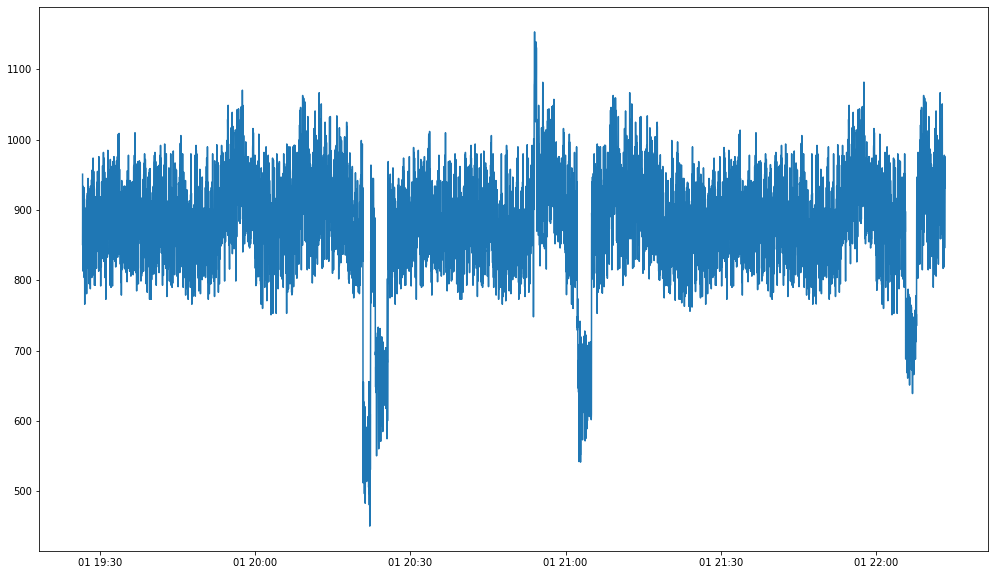

In [17]:
plt.plot(network[70000:80000].index, prediction[:10000])


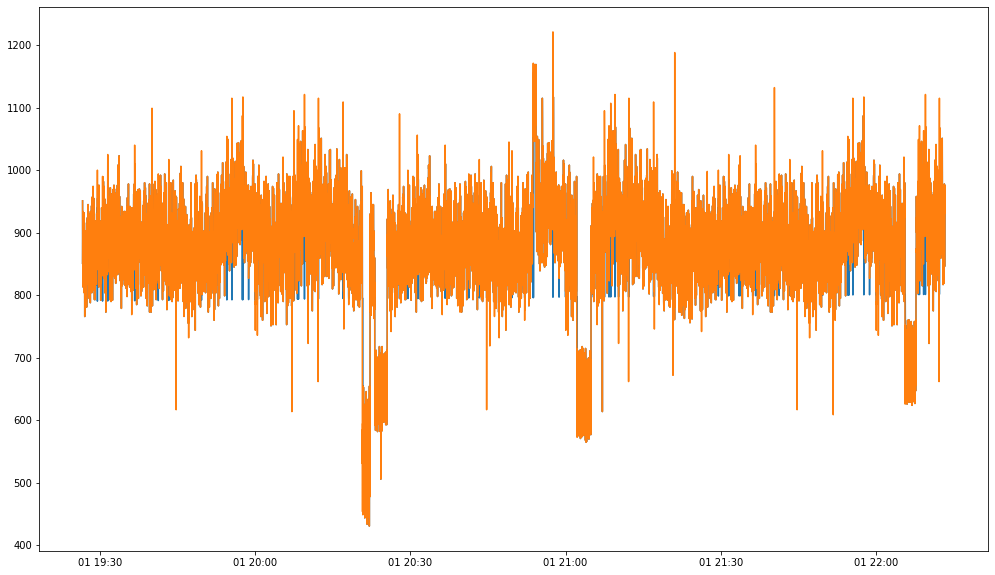

In [23]:
plt.plot(network.index[70000:80000], cleaned)
plt.plot(network[70000:80000])

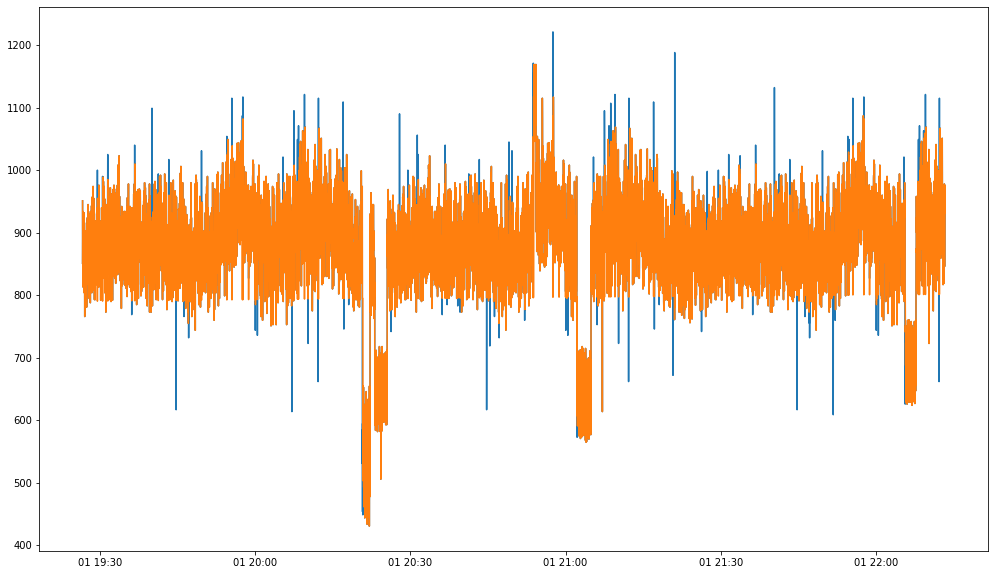

In [22]:
plt.plot(network[70000:80000])
plt.plot(network.index[70000:80000], cleaned)


In [24]:
print(score_for_res(prediction, network[70000:80000]['target']))
print(score_for_res(prediction, cleaned))

0.8578146279501545
0.8922411002637698


ValueError: x and y must have same first dimension, but have shapes (10000,) and (0,)

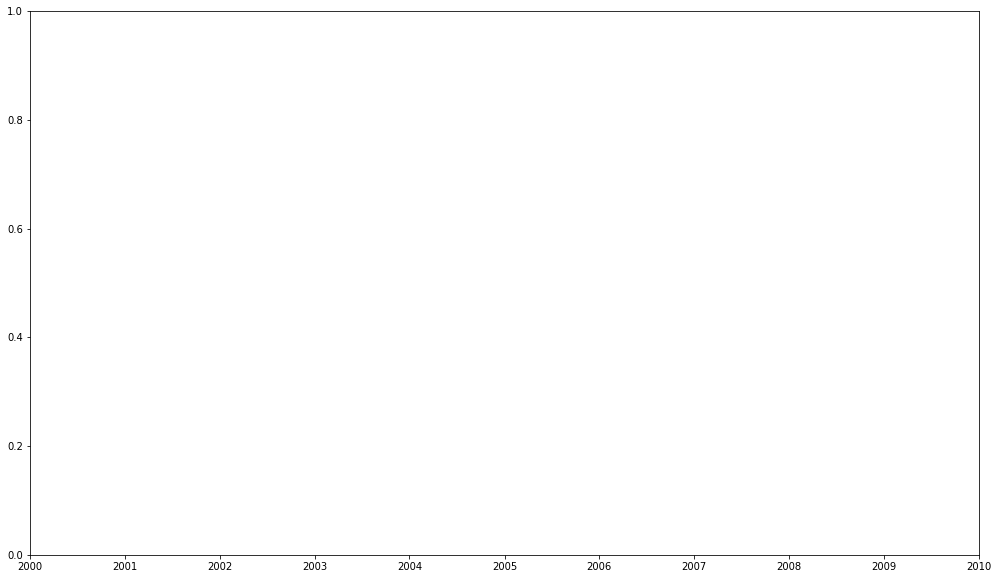

In [21]:
plt.plot(network[50004:60004].index, stdeviation[40000:50000])

In [ ]:
'''
test_sum = ntw_clean.sum()
test_num = ntw_clean.size
yt = 0

print(test_sum)

for i in range(0, 10000) :
    yp = yt
    if (i == 0) : 
        yp = None
    
    yt = network[10004+i:10004+i+1]['target']
    xt['prev1'] = network[10001+i:10001+i+1]['target']
    xt['prev2'] = network[10002+i:10002+i+1]['target']
    xt['prev3'] = network[10003+i:10003+i+1]['target']

    #train의 index가 9999에서 끝났으니까, 10000부터 시작
    index = i+10000
    
    if index > 10050 :
        print(index, z, yt)
        yt = test_sum/test_num
        print(index, z, yt)
        
    y_pred, y_std = partial_train(mfr, xt.values.reshape(1, -1), yt)
    #과거 3개만 저장
    np.roll(xt, -1)
    xt[2] = yt
    
    test_sum += yt.values
    test_num += 1
    print(test_sum)
   
    '''